# Vehicle detection

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
%matplotlib inline

## Manual vehicle detection

(<matplotlib.image.AxesImage at 0x7f304def8780>,
 <matplotlib.text.Text at 0x7f304debee48>)

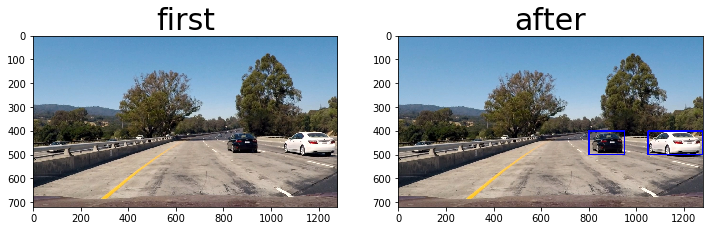

In [5]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

image = mpimg.imread('test_images/1.jpg')
bboxes = [((800, 400), (950, 500)), ((1050, 400), (1280, 500))]
draw_img = draw_boxes(image, bboxes)

f, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=30)
axs[1].imshow(draw_img), axs[1].set_title('manual', fontsize=30)

## Template Matching

(<matplotlib.image.AxesImage at 0x7f304c13df60>,
 <matplotlib.text.Text at 0x7f304c1911d0>)

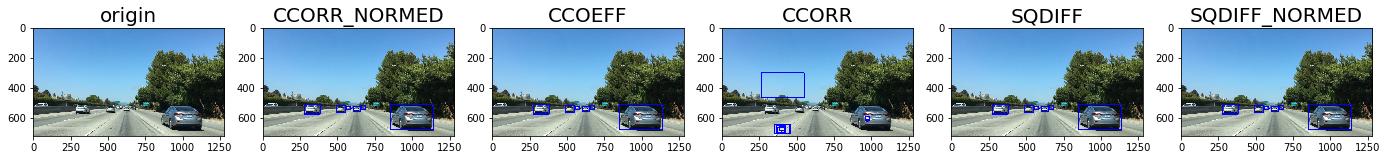

In [22]:
# method: cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF, cv2.TM_CCORR, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED
def find_matches(img, templates, method):
    bbox_list = []
    for template in templates:
        temp_img = mpimg.imread(template)
        match = cv2.matchTemplate(img, temp_img, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
        w, h = (temp_img.shape[1], temp_img.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            left_top = min_loc
        else:
            left_top = max_loc
        right_bottom = (left_top[0] + w, left_top[1] + h)
        bbox_list.append((left_top, right_bottom))
    return bbox_list

image = mpimg.imread('test_images/bbox-example-image.jpg')
templist = glob.glob('test_images/c*.jpg')
bboxes_CCORR_NORMED = find_matches(image, templist, cv2.TM_CCORR_NORMED)
result_CCORR_NORMED = draw_boxes(image, bboxes_CCORR_NORMED)
bboxes_CCOEFF = find_matches(image, templist, cv2.TM_CCOEFF)
result_CCOEFF = draw_boxes(image, bboxes_CCOEFF)
bboxes_CCORR = find_matches(image, templist, cv2.TM_CCORR)
result_CCORR = draw_boxes(image, bboxes_CCORR)
bboxes_SQDIFF = find_matches(image, templist, cv2.TM_SQDIFF)
result_SQDIFF = draw_boxes(image, bboxes_SQDIFF)
bboxes_SQDIFF_NORMED = find_matches(image, templist, cv2.TM_SQDIFF_NORMED)
result_SQDIFF_NORMED = draw_boxes(image, bboxes_SQDIFF_NORMED)

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=20)
axs[1].imshow(result_CCORR_NORMED), axs[1].set_title('CCORR_NORMED', fontsize=20)
axs[2].imshow(result_CCOEFF), axs[2].set_title('CCOEFF', fontsize=20)
axs[3].imshow(result_CCORR), axs[3].set_title('CCORR', fontsize=20)
axs[4].imshow(result_SQDIFF), axs[4].set_title('SQDIFF', fontsize=20)
axs[5].imshow(result_SQDIFF_NORMED), axs[5].set_title('SQDIFF_NORMED', fontsize=20)

## Color Histogram

(<Container object of 32 artists>, <matplotlib.text.Text at 0x7f304460bf60>)

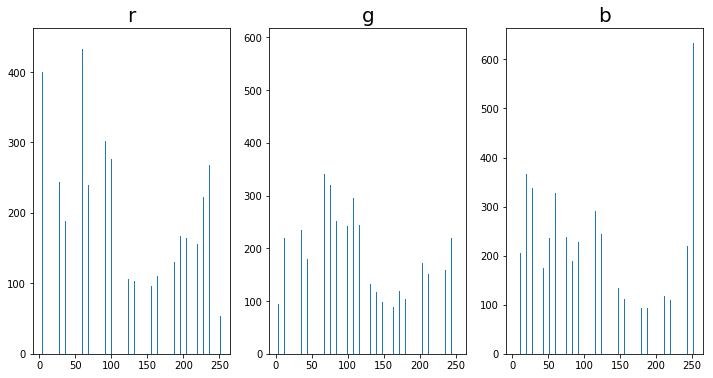

In [42]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # generate bin centers
    bin_edges = rhist[1]
    bin_centers = bin_edges[1:] - bins_range[1] / nbins / 2

    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    return rhist, ghist, bhist, bin_centers, hist_features
    
image = mpimg.imread('test_images/cutout1.jpg')
rhist, ghist, bhist, bin_centers, hist_features = color_hist(image)

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].bar(bin_centers, rhist[0]), axs[0].set_title('r', fontsize=20)
axs[1].bar(bin_centers, ghist[0]), axs[1].set_title('g', fontsize=20)
axs[2].bar(bin_centers, bhist[0]), axs[2].set_title('b', fontsize=20)

## Spatial Binning of Color

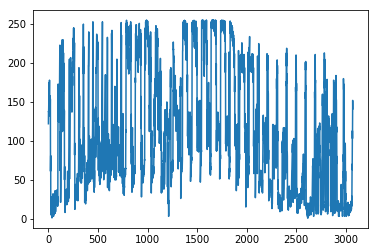

In [45]:
def bin_spatial(img, color_space='RGB', size=(32,32)):
    feature_vec = cv2.resize(img, size).ravel()
    return feature_vec

img = mpimg.imread('test_images/cutout1.jpg')
feature_vec = bin_spatial(img, color_space='RGB', size=(32,32))
plt.plot(feature_vec)

## Data Exploration

In [53]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict['n_cars'] = len(car_list)
    data_dict['n_notcars'] = len(notcar_list)
    image = mpimg.imread(car_list[0])
    data_dict['image_shape'] = image.shape
    data_dict['image_dtype'] = image.dtype
    return data_dict

cars = glob.glob('CarNotCar/Cars/*.jpeg')
notcars = glob.glob('CarNotCar/Notcars/*.jpeg')
data_info = data_look(cars, notcars)
print(data_info)

{'n_notcars': 1125, 'image_shape': (64, 64, 3), 'n_cars': 1196, 'image_dtype': dtype('uint8')}


## HOG

(<matplotlib.image.AxesImage at 0x7f3030b96fd0>,
 <matplotlib.text.Text at 0x7f3030bf80b8>)

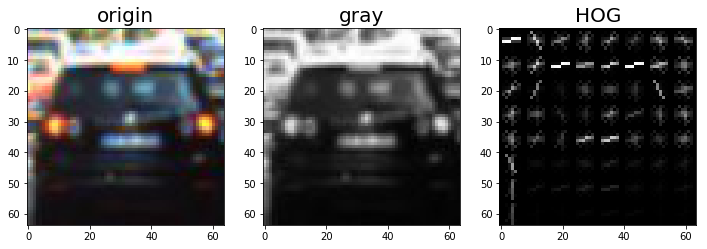

In [59]:
def HOG_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    

ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = HOG_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(image), axs[0].set_title('origin', fontsize=20)
axs[1].imshow(gray, cmap='gray'), axs[1].set_title('gray', fontsize=20)
axs[2].imshow(hog_image, cmap='gray'), axs[2].set_title('HOG', fontsize=20)